In [6]:
import cv2 as cv
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
from keras.layers import Add
from skimage.metrics import peak_signal_noise_ratio as psnr
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from sklearn.model_selection import train_test_split


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
low_img = '/content/drive/MyDrive/Train/low'
high_img = '/content/drive/MyDrive/Train/high'


# Preprocessing

The load_and_preprocess_images function loads images from a specified folder, converts them to the LAB color space, resizes them, and normalizes the pixel values.

In [9]:
def load_and_preprocess_images(folder_path, image_size):
    images = []

    # Iterate over all files in the folder
    for filename in tqdm(sorted(os.listdir(folder_path))):
        if filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            image = cv.imread(image_path)

            image = cv.cvtColor(image, cv.COLOR_BGR2LAB)
            image = cv.resize(image, image_size)
            image = image.astype('float32') / 255.0
            images.append(image)

    return np.array(images)


image_size = (256, 256)

low_images = load_and_preprocess_images(low_img, image_size)
high_images = load_and_preprocess_images(high_img, image_size)

100%|██████████| 485/485 [00:31<00:00, 15.16it/s]


### Splitting the data into train and test dataset for training and validation

In [10]:
X_train, X_val, y_train, y_val = train_test_split(low_images, high_images, test_size=0.1, random_state=48)

## Model Definition
The unet_model function defines a UNet model with residual blocks to enhance image resolution.

In [11]:
def residual_block(input_tensor, filters):
    x = Conv2D(filters, 3, activation='relu', padding='same')(input_tensor)
    x = Conv2D(filters, 3, activation=None, padding='same')(x)
    x = Add()([x, input_tensor])
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [13]:
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = residual_block(conv1, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = residual_block(conv2, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = residual_block(conv3, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = residual_block(conv4, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = residual_block(conv5, 512)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(up6)
    conv6 = residual_block(conv6, 256)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = residual_block(conv7, 128)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = residual_block(conv8, 64)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = residual_block(conv9, 32)

    conv10 = Conv2D(3, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

## Training the Model
Compile and train the UNet model using the preprocessed images.

In [15]:
model_lab = unet_model()
model_lab.compile(optimizer=Adam(learning_rate=1e-4, clipvalue=1.0), loss=MeanAbsoluteError())
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
model_lab.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

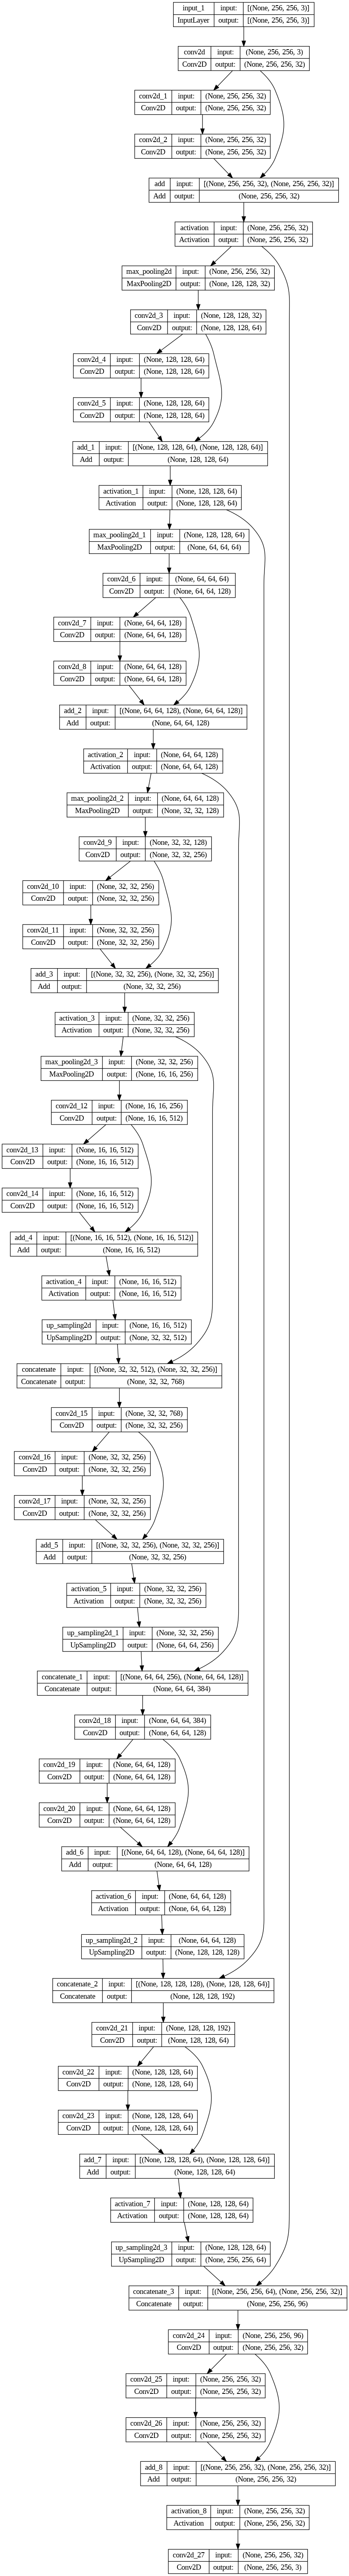

In [17]:
from keras.utils import plot_model
plot_model(model_lab,to_file='model_.png',show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_.png')

In [18]:
model_lab.fit(X_train, y_train,
          epochs=109, batch_size=4)

Epoch 1/109
109/109 [==============================] - 36s 124ms/step - loss: 0.0706
Epoch 2/109
109/109 [==============================] - 14s 125ms/step - loss: 0.0651
Epoch 3/109
109/109 [==============================] - 14s 127ms/step - loss: 0.0607
Epoch 4/109
109/109 [==============================] - 14s 129ms/step - loss: 0.0575
Epoch 5/109
109/109 [==============================] - 14s 131ms/step - loss: 0.0573
Epoch 6/109
109/109 [==============================] - 14s 133ms/step - loss: 0.0556
Epoch 7/109
109/109 [==============================] - 14s 132ms/step - loss: 0.0548
Epoch 8/109
109/109 [==============================] - 14s 130ms/step - loss: 0.0546
Epoch 9/109
109/109 [==============================] - 14s 130ms/step - loss: 0.0538
Epoch 10/109
109/109 [==============================] - 14s 130ms/step - loss: 0.0526
Epoch 11/109
109/109 [==============================] - 14s 132ms/step - loss: 0.0516
Epoch 12/109
109/109 [==============================] - 14s 131

## Evaluation
Evaluate the model using Peak Signal-to-Noise Ratio (PSNR).

In [20]:
prediction = model_lab.predict(X_val, verbose=0)
psnr_values = [psnr(y_true, y_pred) for y_true, y_pred in zip(y_val, prediction)]
average_psnr = np.mean(psnr_values,)
print(f'Average PSNR: {average_psnr}')

Average PSNR: 26.30191342001141


In [26]:
import matplotlib.pyplot as plt


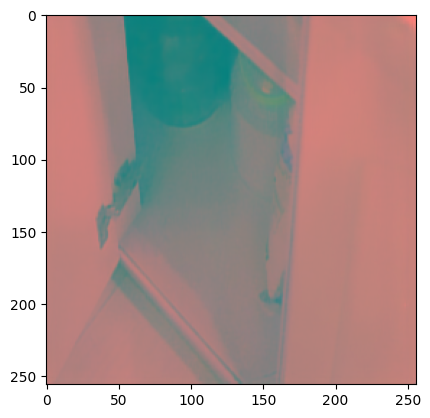

In [27]:
plot = plt.imshow(prediction[10])
plot

In [24]:
import numpy as np

predictions = model_lab.predict(low_images, verbose=0)
def calculate_metrics(true_images, predicted_images):
    mse_values = []
    psnr_values = []
    mae_values = []

    for true, pred in zip(true_images, predicted_images):
        psnr = tf.image.psnr(true, pred, max_val=1.0).numpy()
        psnr_values.append(psnr)
    return np.mean(psnr_values)
psnr = calculate_metrics(high_images, predictions)

print(f'Peak Signal-to-Noise Ratio (PSNR): {psnr}')


Peak Signal-to-Noise Ratio (PSNR): 30.257780075073242


**Peak Signal-to-Noise Ratio (PSNR)** = 30.257780075073242  